In [5]:
import gc
gc.collect()

1687

In [6]:
import psutil
memory_usage = psutil.virtual_memory().percent
print(f"Memory usage: {memory_usage}%")

Memory usage: 81.7%


import neccessary libraries

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import optuna
import shap
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import joblib

Load the datasets

In [8]:
X_train = pd.read_csv(r"D:\Train_60\Train_60\Train_60\X_Train_Data_Input.csv")
Y_train = pd.read_csv(r"D:\Train_60\Train_60\Train_60\Y_Train_Data_Target.csv")
X_test = pd.read_csv(r"D:\Test_20\Test_20\Test_20\X_Test_Data_Input.csv")
Y_test = pd.read_csv(r"D:\Test_20\Test_20\Test_20\Y_Test_Data_Target.csv")


Drop the 'ID' column from both X_train and X_test

In [9]:
X_train = X_train.drop(columns=['ID', 'target'])
X_test = X_test.drop(columns=['ID'])
Y_train = Y_train.drop(columns=['ID'])
Y_test = Y_test.drop(columns=['ID'])


Impute missing values

In [10]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

Convert back to DataFrame

In [11]:
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

Standardize the features

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

Convert back to DataFrame

In [13]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Calculate VIF

In [14]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
print(vif_data)

     feature       VIF
0    Column0  1.054533
1    Column1  1.488827
2    Column2  1.103574
3    Column3  4.862719
4    Column4  5.178206
5    Column5  1.000114
6    Column6  1.165029
7    Column7  1.024339
8    Column8  1.261413
9    Column9  1.026054
10  Column10  4.106833
11  Column11  4.590756
12  Column12  3.894457
13  Column13  4.374858
14  Column14  1.000211
15  Column15  1.000613
16  Column16  1.020774
17  Column17  1.092544
18  Column18  1.249391
19  Column19  1.157325
20  Column20  1.140316
21  Column21  1.098497


In [15]:
# Drop Column4 due to high VIF
columns_to_drop = ['Column4']

X_train_reduced = X_train_scaled.drop(columns=columns_to_drop, axis=1)
X_test_reduced = X_test_scaled.drop(columns=columns_to_drop, axis=1)

# Recompute VIF after dropping the column to verify if it reduces multicollinearity
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = X_train_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_train_reduced.values, i) for i in range(X_train_reduced.shape[1])]
print(vif_data_reduced)

     feature       VIF
0    Column0  1.054531
1    Column1  1.397204
2    Column2  1.102766
3    Column3  1.099390
4    Column5  1.000113
5    Column6  1.164084
6    Column7  1.024330
7    Column8  1.260642
8    Column9  1.026039
9   Column10  4.106157
10  Column11  4.590508
11  Column12  3.889872
12  Column13  4.373771
13  Column14  1.000211
14  Column15  1.000597
15  Column16  1.020620
16  Column17  1.091214
17  Column18  1.242985
18  Column19  1.157106
19  Column20  1.139414
20  Column21  1.098446


Split the data

In [16]:
X_train_reduced, X_val, Y_train, Y_val = train_test_split(X_train_reduced, Y_train, test_size=0.2, random_state=42)

Optuna for hyperparameter tuning

In [17]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )
    
    return cross_val_score(rf_model, X_train_reduced, Y_train, cv=5, n_jobs=-1).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4) 

best_params = study.best_params
final_rf_model = RandomForestClassifier(**best_params, random_state=42)
final_rf_model.fit(X_train_reduced, Y_train.values.ravel())

[I 2024-10-11 20:58:12,444] A new study created in memory with name: no-name-1423031d-e782-4009-80e0-3717536ea95c
[I 2024-10-11 21:02:04,861] Trial 0 finished with value: 0.976074101994738 and parameters: {'n_estimators': 136, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.976074101994738.
[I 2024-10-11 21:04:00,189] Trial 1 finished with value: 0.9769545267454411 and parameters: {'n_estimators': 134, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9769545267454411.
[I 2024-10-11 21:05:24,494] Trial 2 finished with value: 0.9761775879655913 and parameters: {'n_estimators': 114, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.9769545267454411.
[I 2024-10-11 21:07:06,084] Trial 3 finished with value: 0.9766249647608414 and parameters: {'n_estimators': 130, 'max_depth': 16, 'min_s

RandomForestClassifier(max_depth=25, min_samples_split=9, n_estimators=134,
                       random_state=42)

Make predictions

In [18]:
y_val_pred = final_rf_model.predict(X_val)

Evaluate the model

In [19]:
accuracy = accuracy_score(Y_val, y_val_pred)
conf_matrix = confusion_matrix(Y_val, y_val_pred)
class_report = classification_report(Y_val, y_val_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.98
Confusion Matrix:
[[139674   2601]
 [   994  13758]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    142275
           1       0.84      0.93      0.88     14752

    accuracy                           0.98    157027
   macro avg       0.92      0.96      0.94    157027
weighted avg       0.98      0.98      0.98    157027



cross-validation score

In [20]:
cv_scores = cross_val_score(final_rf_model, X_train_reduced, Y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

C:\Users\MUTHU SELVI\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\MUTHU SELVI\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\MUTHU SELVI\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\MUTHU SELVI\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column

Cross-Validation Scores: [0.97718552 0.97635746 0.97655647 0.97716146 0.9775356 ]
Mean CV Accuracy: 0.9769593026874093


ROC-AUC score

In [21]:
y_proba = final_rf_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(Y_val, y_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

ROC-AUC Score: 0.99


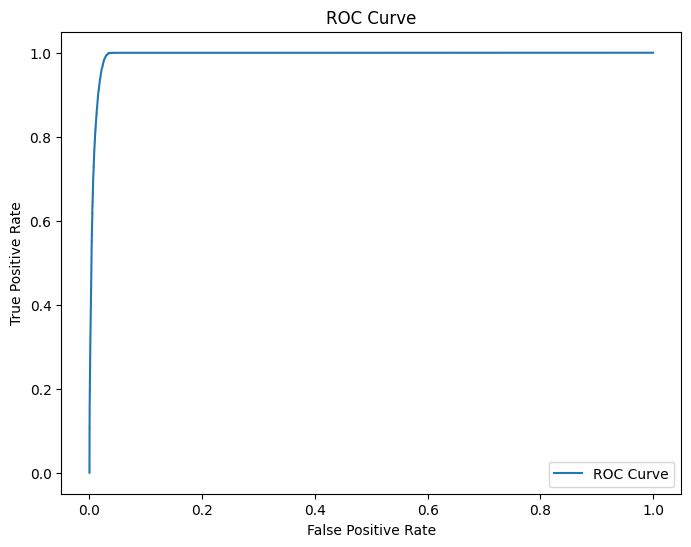

In [22]:
# ROC Curve visualization
fpr, tpr, _ = roc_curve(Y_val, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [23]:
# Feature interactions or polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [24]:
# PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

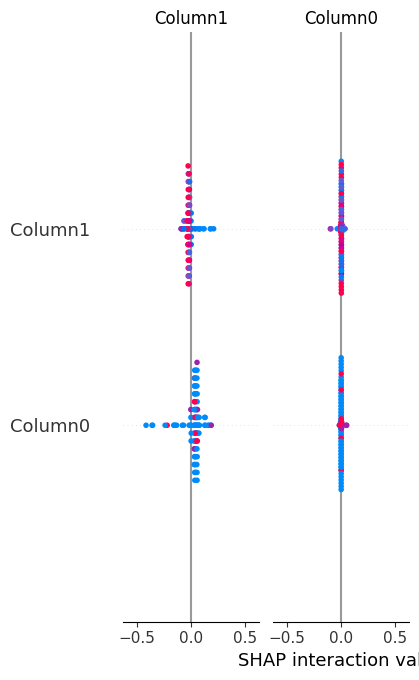

In [28]:
# Use TreeExplainer
explainer = shap.TreeExplainer(final_rf_model)

# Sample a subset of X_val (if necessary) to avoid memory issues
sample_X_val = X_val.sample(n=100, random_state=42)  # Adjust sample size based on your memory

# Get SHAP values for the sample
shap_values = explainer.shap_values(sample_X_val)

# Check if shap_values is a list (in case of binary classification)
if isinstance(shap_values, list):
    # Use the SHAP values for the positive class (index 1)
    shap.summary_plot(shap_values[1], sample_X_val)
else:
    # For non-binary cases, or if shap_values is not a list
    shap.summary_plot(shap_values, sample_X_val)

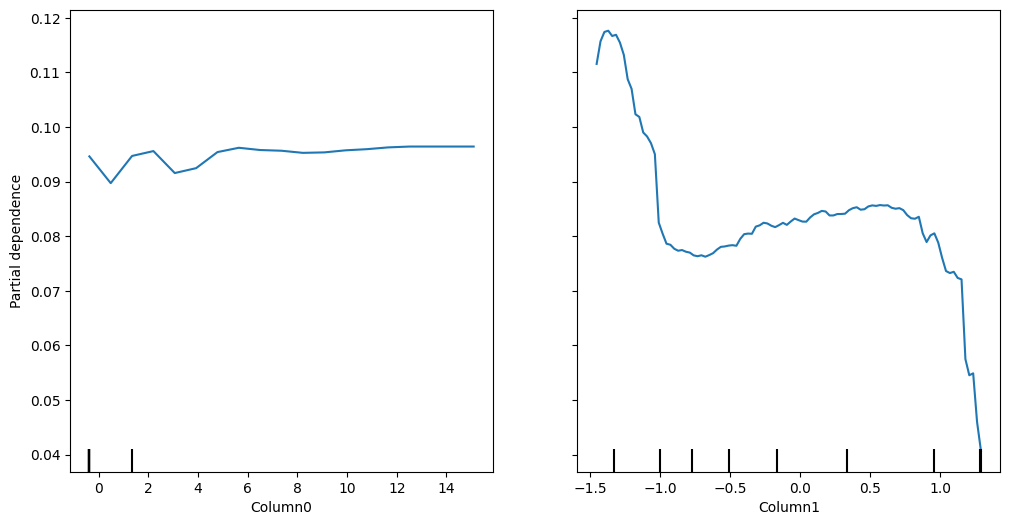

In [29]:
# Partial Dependence Plot (PDP)
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(final_rf_model, X_train_reduced, [0, 1], ax=ax)

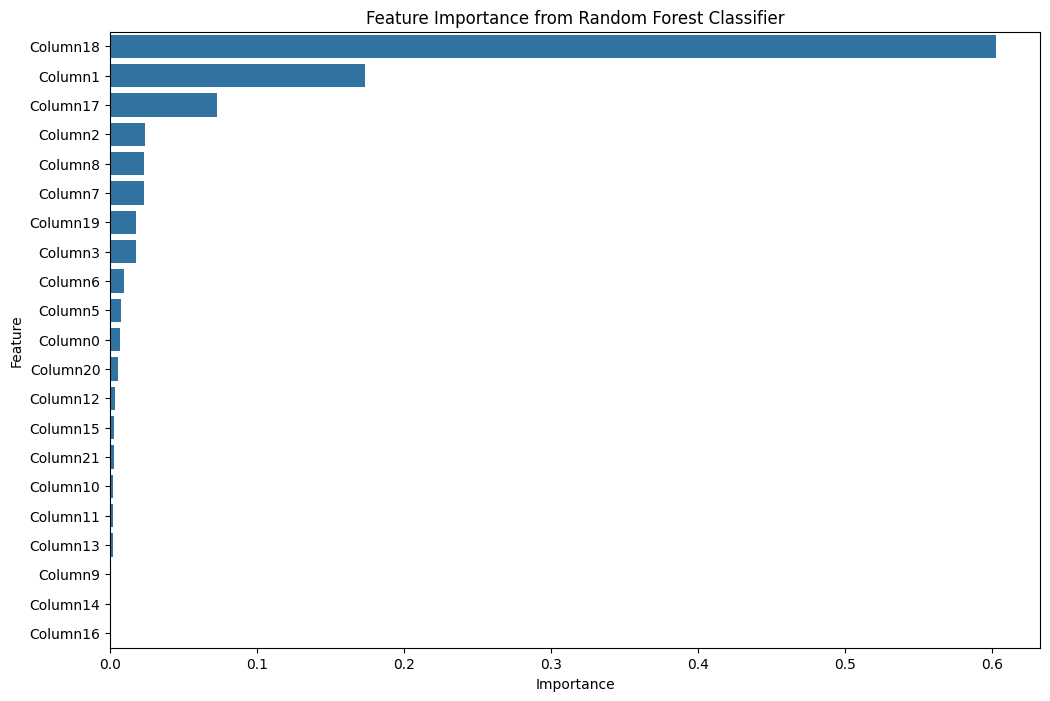

In [38]:
# Retrieve feature importance
importances = final_rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Importance': importances
})

# Sort the DataFrame based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()

In [39]:
# Specify the columns to drop by their names or indices
columns_to_drop = ['Column9', 'Column14', 'Column16']  # Adjust the names based on your actual DataFrame

# Drop the specified columns from X_train_reduced and X_test_reduced
X_train_final = X_train_reduced.drop(columns=columns_to_drop, axis=1)
X_test_final = X_test_reduced.drop(columns=columns_to_drop, axis=1)

# Output the new shapes
print("Dropped Columns:", columns_to_drop)
print("New shape of X_train:", X_train_final.shape)
print("New shape of X_test:", X_test_final.shape)


Dropped Columns: ['Column9', 'Column14', 'Column16']
New shape of X_train: (628106, 18)
New shape of X_test: (261712, 18)


In [41]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")

Shape of X_train: (51496, 22)
Shape of Y_train: (628106, 1)


In [43]:
print("Duplicates in X_train:", X_train.index.duplicated().sum())
print("Duplicates in Y_train:", Y_train.index.duplicated().sum())

Duplicates in X_train: 0
Duplicates in Y_train: 0


In [ ]:
# Pipeline creation
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(**best_params, random_state=42))
])

pipeline.fit(X_train, Y_train.values.ravel())

In [46]:
# Save the model
joblib.dump(final_rf_model, 'final_rf_model.pkl')

['final_rf_model.pkl']